# Execution Time Comparison: CCC-GPU vs CCC vs Spearman vs Pearson

This notebook combines benchmark results from:
1. Spearman and Pearson correlation benchmarks (12 cores)
2. CCC-GPU vs CCC benchmarks (12 cores)

And generates an execution time comparison chart on a log scale.

In [85]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [86]:
# Configuration
SAVE_OUTPUTS = False  # Set to True to save plots and CSV files

## Parse Spearman and Pearson Results

In [87]:
def parse_spearman_pearson_results(csv_path):
    """
    Parse Spearman and Pearson benchmark results from CSV.
    
    Args:
        csv_path: Path to the benchmark results CSV file
        
    Returns:
        DataFrame with columns: method, n_features, n_samples, time_seconds
    """
    df = pd.read_csv(csv_path)
    
    # Parse the shape tuple string to extract n_features and n_samples
    # Shape format: "(n_features, n_samples)"
    shape_pattern = r'\((\d+),\s*(\d+)\)'
    df[['n_features', 'n_samples']] = df['shape'].str.extract(shape_pattern).astype(int)
    
    # Select relevant columns
    result = df[['method', 'n_features', 'n_samples', 'time_seconds']].copy()
    result = result.sort_values('n_features')
    
    return result

In [88]:
# Load Spearman and Pearson results
spearman_pearson_csv = 'analysis/03-manuscript/90_benchmarking/spearman-and-pearson/manuscript_results/benchmark_results_20250529_233432.csv'
df_sp = parse_spearman_pearson_results(spearman_pearson_csv)

print(f"Loaded {len(df_sp)} Spearman/Pearson benchmark results")
print(f"\nMethods: {df_sp['method'].unique()}")
print(f"Feature sizes: {sorted(df_sp['n_features'].unique())}")
df_sp.head(10)

Loaded 18 Spearman/Pearson benchmark results

Methods: ['pearson' 'spearman']
Feature sizes: [500, 1000, 2000, 4000, 6000, 8000, 10000, 16000, 20000]


,method,n_features,n_samples,time_seconds
0,pearson,500,1000,0.040997
1,spearman,500,1000,0.062073
2,pearson,1000,1000,0.158776
3,spearman,1000,1000,0.201425
4,pearson,2000,1000,0.627601
5,spearman,2000,1000,0.715025
6,pearson,4000,1000,2.474734
7,spearman,4000,1000,2.670223
8,pearson,6000,1000,5.862554
9,spearman,6000,1000,6.039226


## Parse CCC-GPU Results

In [89]:
def parse_filename(filename):
    """
    Parse CCC-GPU log filename to extract parameters.
    Example: test_ccc_gpu_42_f500_n1000_c6.log
    Returns: (seed, features, samples, cores)
    """
    pattern = r'test_ccc_gpu_(\d+)_f(\d+)_n(\d+)_c(\d+)\.log'
    match = re.match(pattern, filename)
    if match:
        seed = int(match.group(1))
        features = int(match.group(2))
        samples = int(match.group(3))
        cores = int(match.group(4))
        return seed, features, samples, cores
    return None

def parse_log_content(filepath):
    """
    Parse log file content to extract GPU time and CPU time.
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    gpu_time_match = re.search(r'GPU time: ([\d.]+) seconds', content)
    cpu_time_match = re.search(r'CPU time: ([\d.]+) seconds', content)
    
    if gpu_time_match and cpu_time_match:
        gpu_time = float(gpu_time_match.group(1))
        cpu_time = float(cpu_time_match.group(1))
        return gpu_time, cpu_time
    return None

def collect_ccc_gpu_data(logs_dir, target_cores=12):
    """
    Collect CCC-GPU and CCC benchmark data from log files.
    
    Args:
        logs_dir: Directory containing log files
        target_cores: Only collect data for this core count (default: 12)
        
    Returns:
        DataFrame with columns: n_features, n_samples, gpu_time, cpu_time
    """
    data = []
    
    for filename in os.listdir(logs_dir):
        if not filename.endswith('.log'):
            continue
        
        # Parse filename
        parsed_filename = parse_filename(filename)
        if not parsed_filename:
            continue
        
        seed, features, samples, cores = parsed_filename
        
        # Only collect data for target core count
        if cores != target_cores:
            continue
        
        # Parse log content
        filepath = os.path.join(logs_dir, filename)
        parsed_content = parse_log_content(filepath)
        if not parsed_content:
            continue
        
        gpu_time, cpu_time = parsed_content
        
        data.append({
            'n_features': features,
            'n_samples': samples,
            'gpu_time': gpu_time,
            'cpu_time': cpu_time,
            'filename': filename
        })
    
    df = pd.DataFrame(data)
    df = df.sort_values('n_features')
    return df

In [90]:
# Load CCC-GPU results (12 cores only)
ccc_logs_dir = 'analysis/03-manuscript/90_benchmarking/ccc-vs-cccgpu/manuscript_results/scale_on_n_features'
df_ccc = collect_ccc_gpu_data(ccc_logs_dir, target_cores=12)

print(f"Loaded {len(df_ccc)} CCC-GPU benchmark results (12 cores)")
print(f"Feature sizes: {sorted(df_ccc['n_features'].unique())}")
df_ccc.head(10)

Loaded 9 CCC-GPU benchmark results (12 cores)
Feature sizes: [500, 1000, 2000, 4000, 6000, 8000, 10000, 16000, 20000]


,n_features,n_samples,gpu_time,cpu_time,filename
6,500,1000,0.2787,4.6033,test_ccc_gpu_42_f500_n1000_c12.log
1,1000,1000,0.5285,16.1984,test_ccc_gpu_42_f1000_n1000_c12.log
4,2000,1000,1.3836,63.2630,test_ccc_gpu_42_f2000_n1000_c12.log
0,4000,1000,4.2895,255.0707,test_ccc_gpu_42_f4000_n1000_c12.log
3,6000,1000,8.4410,569.4090,test_ccc_gpu_42_f6000_n1000_c12.log
2,8000,1000,14.1160,1009.0690,test_ccc_gpu_42_f8000_n1000_c12.log
8,10000,1000,21.6944,1570.2689,test_ccc_gpu_42_f10000_n1000_c12.log
7,16000,1000,55.4690,4051.1141,test_ccc_gpu_42_f16000_n1000_c12.log
5,20000,1000,86.2863,6374.7806,test_ccc_gpu_42_f20000_n1000_c12.log


## Combine Data

In [91]:
# Create combined dataset for plotting
# Extract individual method data
pearson_data = df_sp[df_sp['method'] == 'pearson'][['n_features', 'time_seconds']].copy()
pearson_data.columns = ['n_features', 'pearson_time']

spearman_data = df_sp[df_sp['method'] == 'spearman'][['n_features', 'time_seconds']].copy()
spearman_data.columns = ['n_features', 'spearman_time']

ccc_data = df_ccc[['n_features', 'gpu_time', 'cpu_time']].copy()
ccc_data.columns = ['n_features', 'ccc_gpu_time', 'ccc_cpu_time']

# Merge all data on n_features
combined_df = ccc_data.merge(pearson_data, on='n_features', how='outer')
combined_df = combined_df.merge(spearman_data, on='n_features', how='outer')
combined_df = combined_df.sort_values('n_features')

print("\nCombined Dataset:")
print(combined_df)


Combined Dataset:
   n_features  ccc_gpu_time  ccc_cpu_time  pearson_time  spearman_time
0         500        0.2787        4.6033      0.040997       0.062073
1        1000        0.5285       16.1984      0.158776       0.201425
2        2000        1.3836       63.2630      0.627601       0.715025
3        4000        4.2895      255.0707      2.474734       2.670223
4        6000        8.4410      569.4090      5.862554       6.039226
5        8000       14.1160     1009.0690     10.395787      10.797427
6       10000       21.6944     1570.2689     16.292878      16.756792
7       16000       55.4690     4051.1141     41.968231      42.622779
8       20000       86.2863     6374.7806     65.397915      66.537973


## Execution Time Comparison Chart

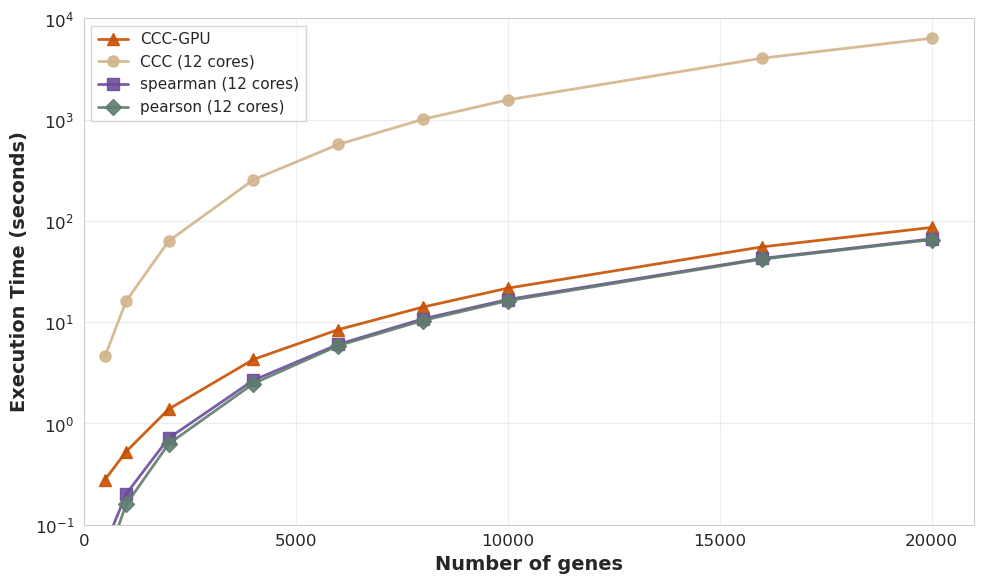

In [92]:
# Set style for publication-quality plots
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and markers matching the reference image
# CCC-GPU: red/orange triangle
# CCC (12 cores): tan/beige circle
# Spearman (12 cores): purple square
# Pearson (12 cores): dark gray diamond

colors = {
    'ccc_gpu': '#C75000',      # Orange-red
    'ccc': '#D2B48C',          # Tan/beige
    'spearman': '#6B4C9A',     # Purple
    'pearson': '#5F7C6E'       # Dark gray-green
}

markers = {
    'ccc_gpu': '^',    # Triangle
    'ccc': 'o',        # Circle
    'spearman': 's',   # Square
    'pearson': 'D'     # Diamond
}

# Plot each method
# CCC-GPU
ax.plot(combined_df['n_features'], combined_df['ccc_gpu_time'],
        marker=markers['ccc_gpu'],
        markersize=8,
        linewidth=2,
        color=colors['ccc_gpu'],
        label='CCC-GPU',
        alpha=0.9)

# CCC (12 cores)
ax.plot(combined_df['n_features'], combined_df['ccc_cpu_time'],
        marker=markers['ccc'],
        markersize=8,
        linewidth=2,
        color=colors['ccc'],
        label='CCC (12 cores)',
        alpha=0.9)

# Spearman (12 cores)
ax.plot(combined_df['n_features'], combined_df['spearman_time'],
        marker=markers['spearman'],
        markersize=8,
        linewidth=2,
        color=colors['spearman'],
        label='spearman (12 cores)',
        alpha=0.9)

# Pearson (12 cores)
ax.plot(combined_df['n_features'], combined_df['pearson_time'],
        marker=markers['pearson'],
        markersize=8,
        linewidth=2,
        color=colors['pearson'],
        label='pearson (12 cores)',
        alpha=0.9)

# Formatting
ax.set_xlabel('Number of genes', fontweight='bold', fontsize=14)
ax.set_ylabel('Execution Time (seconds)', fontweight='bold', fontsize=14)

# Set x-axis to linear scale with specific ticks
ax.set_xlim(0, 21000)
ax.set_xticks([0, 5000, 10000, 15000, 20000])

# Set y-axis to log scale with extended range
ax.set_yscale('log')
ax.set_ylim(10**-1, 10**4)

# Add grid with light gray color
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8, color='lightgray')

# Add legend at top left
ax.legend(loc='upper left', frameon=True, fancybox=False, shadow=False)

# Adjust layout
plt.tight_layout()

# Save figure if SAVE_OUTPUTS is True
if SAVE_OUTPUTS:
    output_file = 'analysis/03-manuscript/90_benchmarking/spearman-and-pearson/execution_time_comparison.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Chart saved to: {output_file}")

plt.show()

## Export Combined Data

In [93]:
# Export combined data to CSV for further analysis
if SAVE_OUTPUTS:
    output_csv = 'analysis/03-manuscript/90_benchmarking/spearman-and-pearson/combined_benchmark_results.csv'
    combined_df.to_csv(output_csv, index=False)
    print(f"Combined data exported to: {output_csv}")
else:
    print("CSV export skipped (set SAVE_OUTPUTS = True to enable)")

CSV export skipped (set SAVE_OUTPUTS = True to enable)


## Summary Statistics

In [94]:
# Show summary statistics
print("\nExecution Time Summary (in seconds):")
print("\nCCC-GPU:")
print(combined_df['ccc_gpu_time'].describe())
print("\nCCC (12 cores):")
print(combined_df['ccc_cpu_time'].describe())
print("\nSpearman (12 cores):")
print(combined_df['spearman_time'].describe())
print("\nPearson (12 cores):")
print(combined_df['pearson_time'].describe())


Execution Time Summary (in seconds):

CCC-GPU:
count     9.000000
mean     21.387444
std      29.931506
min       0.278700
25%       1.383600
50%       8.441000
75%      21.694400
max      86.286300
Name: ccc_gpu_time, dtype: float64

CCC (12 cores):
count       9.000000
mean     1545.975222
std      2219.699776
min         4.603300
25%        63.263000
50%       569.409000
75%      1570.268900
max      6374.780600
Name: ccc_cpu_time, dtype: float64

Spearman (12 cores):
count     9.000000
mean     16.266994
std      23.194827
min       0.062073
25%       0.715025
50%       6.039226
75%      16.756792
max      66.537973
Name: spearman_time, dtype: float64

Pearson (12 cores):
count     9.000000
mean     15.913275
std      22.840681
min       0.040997
25%       0.627601
50%       5.862554
75%      16.292878
max      65.397915
Name: pearson_time, dtype: float64
